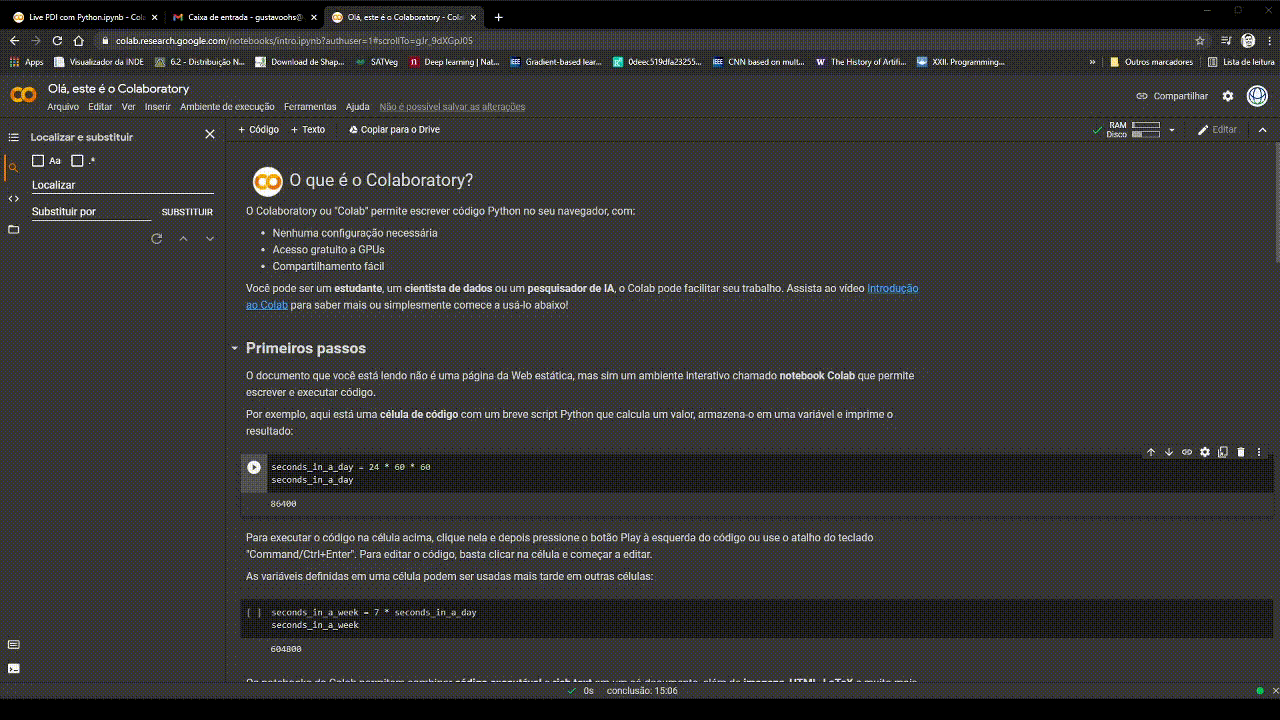

# Bibliotecas

In [ ]:
# Instalando bibliotecas
!pip install -q spectral
!pip install -q rasterio

     |████████████████████████████████| 212 kB 4.0 MB/s 
     |████████████████████████████████| 19.3 MB 1.2 MB/s 


In [ ]:
# Importando bibliotecas
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from spectral import imshow 
from rasterio.plot import reshape_as_raster
import rasterio as rio

# Leitura do arquivo de imagem

In [ ]:
# Lendo imagem como array
src = rio.open('/content/drive/MyDrive/Crosta/Rmount.tif')
b1 = src.read(1)
b2 = src.read(2)
b3 = src.read(3)
b4 = src.read(4)
b5 = src.read(5)
b7 = src.read(6)


In [ ]:
# Armazenando metadados
meta = src.profile

In [ ]:
img_H = np.dstack([b1,b4,b5,b7])
img_F = np.dstack([b1,b3,b4,b5])

# Funções para fluxo

In [ ]:
def pca(img):
  #Cálculo dos autovetores e autovalores
  Matriz = img.reshape(img.shape[0]*img.shape[1], img.shape[2])


  cov = np.cov(Matriz.T)#Calculando a matriz de covariância entre as bandas
  autoval,autovec = np.linalg.eig(cov)#Calculando autovetores e autovalores
  #Ordenando autovetores e autovalores
  ord = autoval.argsort()[::-1]#Função que retorna os índices para ordenar um array
  autoval = autoval[ord]
  autovec = autovec[:,ord]

  #Computando as componentes  
  PC = np.matmul(Matriz,autovec)

  PC_2D = PC.reshape(img.shape[0],img.shape[1],img.shape[2])
  return autovec, PC_2D


In [ ]:
def autovec_tab(auto_v, bands):
  # Formatando saída de valores numéricos
  pd.options.display.float_format = '{:,.3f}'.format
  # Criando dataFrame
  df = pd.DataFrame(auto_v.T, columns=bands)
  return df

In [ ]:
def vis(array):
  #Plotando as PCs separadamente
  fig,axes = plt.subplots(2,2,figsize=(30,13),sharex='all', sharey='all')
  fig.suptitle('Principais Componentes', fontsize=30)


  axes = axes.ravel()
  for i in range(array.shape[2]):
      axes[i].imshow(array[:,:,i],cmap='gray')
      axes[i].set_title('PC '+str(i+1),fontsize=25)
      axes[i].axis('off')
  return plt.show()

In [ ]:
#Função de expansão
def expansao(img, percent_ini=2, percent_fim=98):
    s = np.zeros_like(img)
    x,y = 0,255  
    w = np.percentile(img, percent_ini)
    z = np.percentile(img, percent_fim)        
    p = x + (img - w) * (y - x) / (z - w)    
    p[p<x] = x
    p[p>y] = y
    s = p
    return s

# Fluxo para Hidroxila

In [ ]:
auto_H, PC_H = pca(img_H)

In [ ]:
df = autovec_tab(auto_H,['B1','B4','B5','B7'])
df

In [ ]:
vis(PC_H)

In [ ]:
plt.figure(figsize=(12,8))
plt.imshow(expansao(PC_H[:,:,-1]), cmap='gray')

# Fluxo para óxido de Ferro

In [ ]:
auto_F, PC_F = pca(img_F)

In [ ]:
df = autovec_tab(auto_F,['B1','B3','B4','B5'])
df

In [ ]:
vis(PC_F)

In [ ]:
plt.figure(figsize=(12,8))
plt.imshow(expansao(PC_F[:,:,-1]), cmap='gray')

# Composição colorida

In [ ]:
# Definindo componentes 
F = PC_F[:,:,-1]*-1
H = PC_H[:,:,-1]

In [ ]:
# Empilhando componentes
comp = np.dstack([H,H+F,F])

In [ ]:
# Visualizando composição
imshow(comp, (0,1,2), stretch=(0.02,0.98), figsize=(12,8))

# Gravando resultado em disco

In [ ]:
# Atualizando número de bandas
meta.update({'count': 3})

In [ ]:
# Formatando resultado para objeto rasterio
comp_rio = reshape_as_raster(comp)

In [ ]:
# Gravando em disco
with rio.open('final.tif', 'w', **meta) as src:
    src.write(comp_rio)